In [1]:
# Required modules
import os
import sys
sys.path.append('../OceanVIM/notebooks/')
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pygmt

import VIM_tools as vt
import pyshtools
from scipy.interpolate import RectSphereBivariateSpline


%matplotlib inline
%load_ext autoreload
%autoreload 2

HM = np.loadtxt('grids/W19_l90.xyz')

lons = HM[:,0].reshape(720,1440)
lats = HM[:,1].reshape(720,1440)
sus = HM[:,2].reshape(720,1440)

sus = np.hstack((sus[:,720:],sus[:,:720]))
lons = np.hstack((lons[:,720:],lons[:,:720]+360))



/mnt/c/Users/siwil/GIT/GPlatesReconstructionModel/gprm/GPlatesReconstructionModel.py:56: UserWarning: web service options not available
  warnings.warn('web service options not available')


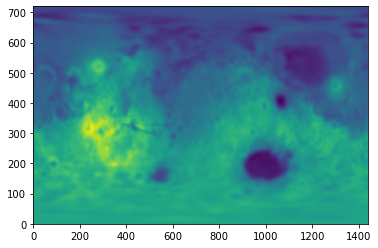

In [2]:
#sus_test = np.zeros_like(sus)
#sus_test[350:480,100:140] = 5.
#sus_test = np.random.random(sus.shape)*10.

sus_test = np.copy(sus)*0.0001

plt.pcolormesh(sus_test)


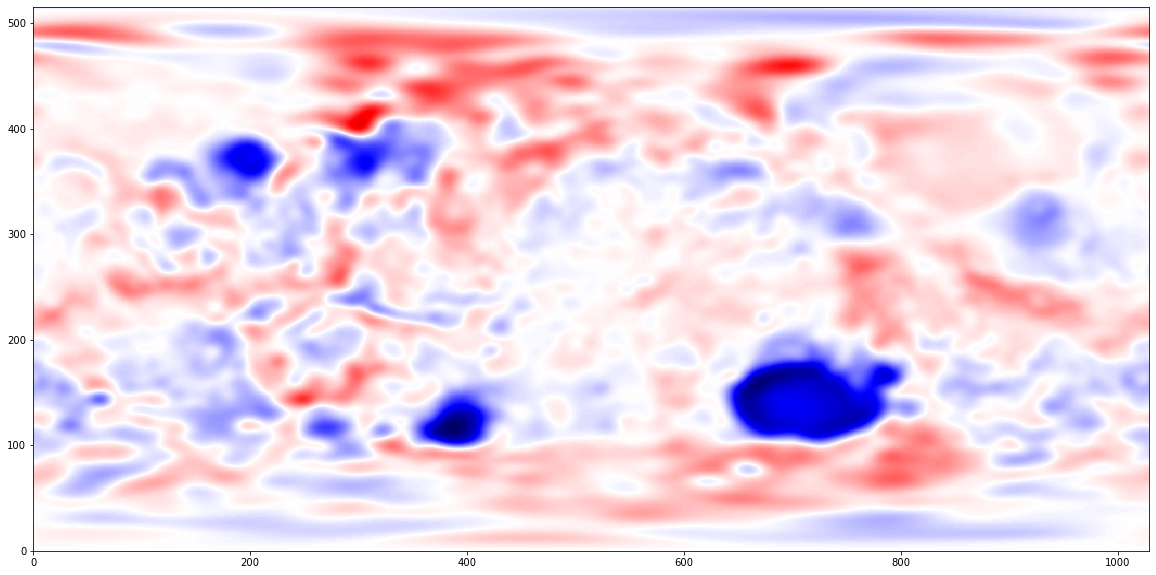

In [3]:
(HM_IVIM_Mr, 
 HM_IVIM_Mtheta, 
 HM_IVIM_Mphi) = vt.vis2magnetisation(np.flipud(sus_test))


vt.write_vh0_input(lons[0,:].flatten(),90-lats[:,0].flatten(),HM_IVIM_Mr,HM_IVIM_Mtheta,HM_IVIM_Mphi,filename='total_py.in')

os.system('vh0 < total_py.in')

# The skip is to remove lines for harmonic degrees 14 and lower 
coeffs, lmaxout = pyshtools.shio.shread('./glm.out')#,skip=104)


r0 = 6371000.
alt = 300000.

result = pyshtools.SHMagCoeffs.from_array(coeffs, r0=r0)

resultg = result.expand(a=r0+alt, sampling=2, extend=True)

plt.figure(figsize=(20,10))
plt.pcolormesh(-resultg.rad.to_array(),vmin=-100,vmax=100,cmap=plt.cm.seismic)



(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='Spherical harmonic degree', ylabel='Power, nT$^2$'>)

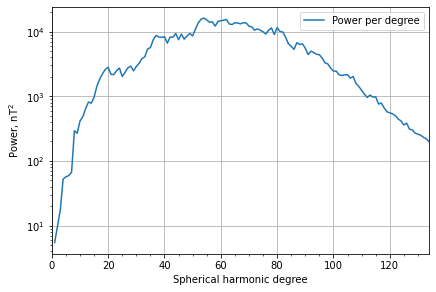

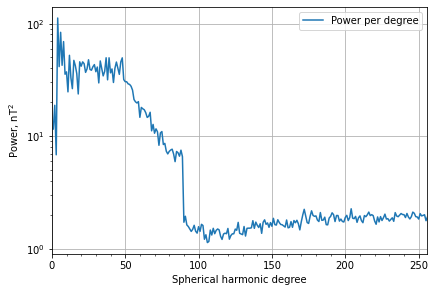

In [8]:
# Load coefficients for Mars magnetic model of Langlais++ 2018
clm_lang, lmax = pyshtools.shio.shread('./shc/Langlais++_Mars.cof')

clmm = pyshtools.SHMagCoeffs.from_array(clm_lang, r0=3389500.)

clmm.plot_spectrum()
result.plot_spectrum()